In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import networkx as nx
import os

sys.path.insert(0,'/global/homes/b/bpb/repos/blink')
import blink
sys.path.insert(0,'/global/homes/b/bpb/repos/scndb/')
import scndb.tools as wt

INFO:rdkit:Enabling RDKit 2023.09.1 jupyter extensions


In [2]:
G = nx.read_graphml('CarbonNetwork.graphml')

In [10]:

## Export NODE class data to table
df = G.nodes(data=True)
df = pd.DataFrame(df)
df.columns = ['node','data']
df['data'] = df['data'].apply(lambda x: dict(x))
df = pd.concat([df.drop(['data'], axis=1), df['data'].apply(pd.Series)], axis=1)
df.reset_index(inplace=True,drop=True)

cols = [ 'name_identity','inchi_key_identity', 'smiles_identity', 'formula_identity', 'class', 'superclass', 'subclass', 'consensus_class']
df = df[cols]
df = df[pd.notna(df['inchi_key_identity'])]
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True,drop=True)
df.sort_values('subclass',inplace=True)
cols = ['class', 'superclass', 'subclass','consensus_class']
df[cols].drop_duplicates().to_csv('non-redundant_classes.csv',index=None)

In [31]:
import requests
import json

url = 'https://npclassifier.gnps2.org/classify?smiles='
df.reset_index(inplace=True,drop=True)
out = []
for smiles in df['smiles_identity']:
    # smiles = df.loc[0,'smiles_identity']
    r = requests.get('%s%s'%(url,smiles))
    if r.status_code == 200:
        out.append(r.json())
    else:
        out.append({'class_results': None,
                     'superclass_results': None,
                     'pathway_results': None,
                     'isglycoside': False})

In [50]:
out2 = pd.DataFrame(out)
out2.shape,df.shape

((1402, 4), (1402, 8))

In [51]:
out2.columns

Index(['class_results', 'superclass_results', 'pathway_results',
       'isglycoside'],
      dtype='object')

In [52]:
cols = ['class_results', 'superclass_results', 'pathway_results']
for c in cols:
    out2[c] = out2[c].apply(lambda x: ','.join(sorted(x)) if isinstance(x,list) else '')

cols = ['class_results', 'superclass_results', 'pathway_results','isglycoside']
for c in cols:
    out2.rename(columns={c:'npclassifier: %s'%c},inplace=True)

In [57]:
out2['npclassifier: pathway_results'].value_counts()

npclassifier: pathway_results
Shikimates and Phenylpropanoids                             462
Fatty acids                                                 304
Terpenoids                                                  225
Polyketides                                                 123
Amino acids and Peptides                                     95
                                                             63
Alkaloids                                                    57
Amino acids and Peptides,Shikimates and Phenylpropanoids     31
Polyketides,Terpenoids                                       16
Carbohydrates                                                15
Alkaloids,Amino acids and Peptides                            3
Polyketides,Shikimates and Phenylpropanoids                   2
Shikimates and Phenylpropanoids,Terpenoids                    2
Amino acids and Peptides,Polyketides                          2
Amino acids and Peptides,Fatty acids                          1
Alkaloids,

In [54]:

pd.concat([df,out2],axis=1).to_csv('all_assignments_top_identity_matches.csv',index=None)

In [56]:
cols = ['npclassifier: class_results', 'npclassifier: superclass_results',
       'npclassifier: pathway_results', 'npclassifier: isglycoside']

pd.concat([df,out2],axis=1).drop_duplicates(subset=cols).to_csv('non-redundant_npclassifier-classes.csv',index=None)

In [214]:
from blink.utils import filter_top_k, filter_component_additive
# filter_top_k(G,4,'rem_predicted_score')
G_mst = nx.maximum_spanning_tree(G)
print('nodes',len(G_mst.nodes))
print('edges',len(G_mst.edges))
nx.write_graphml(G,'eom-net_0p1_subclass_clusters_mst.graphml')

nodes 11520
edges 8739


In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
G = nx.read_graphml('eom-net_0p1_subclass_clusters.graphml')
df = G.nodes(data=True)
df = pd.DataFrame(df)
df.columns = ['node','data']
df['data'] = df['data'].apply(lambda x: dict(x))
df = pd.concat([df.drop(['data'], axis=1), df['data'].apply(pd.Series)], axis=1)
df.reset_index(inplace=True,drop=True)
df['consensus_class'] = None



In [11]:
# Count the number of occurrences of each subclass
subclass_counts = df['subclass'].value_counts()

# Get the subclasses that have at least 100 values
large_subclasses = subclass_counts[subclass_counts >= 100].index

# Set the consensus_class for large subclasses
df.loc[df['subclass'].isin(large_subclasses), 'consensus_class'] = df.loc[df['subclass'].isin(large_subclasses), 'subclass']

# Get the subclasses that have less than 100 values
small_subclasses = subclass_counts[subclass_counts < 100].index

# Set the consensus_class for small subclasses
df.loc[df['subclass'].isin(small_subclasses), 'consensus_class'] = df.loc[df['subclass'].isin(small_subclasses), 'class']

# Get the subclasses that have less than 100 values
class_counts = df['consensus_class'].value_counts()
small_classes = class_counts[class_counts < 100].index

# Set the consensus_class for small subclasses
df.loc[df['consensus_class'].isin(small_classes), 'consensus_class'] = df.loc[df['consensus_class'].isin(small_classes), 'superclass']

df = df[['node','consensus_class']]

df.loc[df['consensus_class'].map(df['consensus_class'].value_counts()) < 100, 'consensus_class'] = None

df.fillna('',inplace=True)
df.value_counts('consensus_class')
nx.set_node_attributes(G, df.set_index('node')['consensus_class'].to_dict(), 'consensus_class')


consensus_class
                                        4873
Fatty acids and conjugates              2134
Terpene lactones                        1039
Amino acids, peptides, and analogues     870
Benzoic acids and derivatives            708
1-benzopyrans                            372
Eicosanoids                              286
Flavones                                 203
Phenylpropanoids and polyketides         201
Chalcones and dihydrochalcones           158
Organoheterocyclic compounds             157
Prenol lipids                            154
Triterpenoids                            135
Organic acids and derivatives            127
Steroids and steroid derivatives         103
Name: count, dtype: int64

In [13]:
G = nx.maximum_spanning_tree(G)
nx.write_graphml(G, 'graph_with_consensus_class.graphml')


In [215]:
max_weights = {}

for node in G.nodes:
    weights = [data['rem_predicted_score'] for _, _, data in G.edges(node, data=True)]
    if weights:
        max_weights[node] = max(weights)
    else:
        max_weights[node] = None  # or some other value indicating no connections

weights = [v for k,v in max_weights.items() if v is not None]


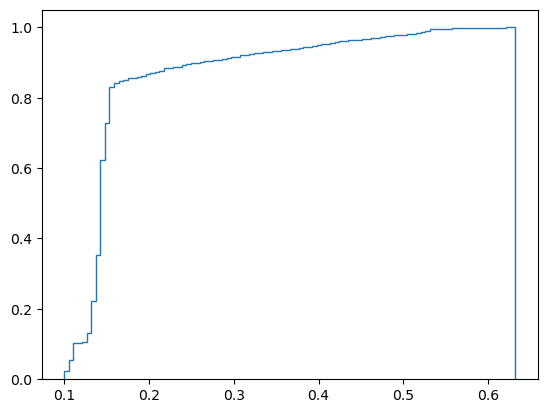

In [219]:
fig,ax = plt.subplots()
# ax.hist(weights,bins=100)
ax.hist(weights, bins=100, density=True, histtype="step",
                               cumulative=True, label="Cumulative histogram")
# ax.set_xlim(0)
# ax.set_yscale('log')
plt.show()

In [2]:
# import networkx as nx
# import matplotlib.pyplot as plt
# G = nx.read_graphml('eom-net_0p1_subclass_clusters_mst.graphml')

# pos = nx.nx_agraph.graphviz_layout(G, prog='neato')

# nx.draw(G, pos, with_labels=False, font_weight='bold', node_color='lightblue', node_size=30)
# plt.title("Nodes associated with a structural cluster")
# plt.show()

In [ ]:

# Get identity hits smiles for all nodes
identity_smiles = nx.get_node_attributes(G, smiles_col)
nodes_with_hits = list(identity_smiles.keys())

# Get all node pairs within distance
neighbor_distance_matrix = distance_matrix <= max_node_distance
rows, cols = neighbor_distance_matrix.nonzero()
neighbor_pairs = np.array([rows, cols]).T

# # Define a function to compute jaccard bonds
# def compute_jaccard_bonds_parallel(args):
#     pair, nodes, nodes_with_hits, identity_smiles = args
#     node0 = nodes[pair[0]]
#     node1 = nodes[pair[1]]
    
#     if node0 not in nodes_with_hits or node1 not in nodes_with_hits:
#         return 0
#     else:
#         smiles0 = identity_smiles[node0]
#         smiles1 = identity_smiles[node1]
        
#         return compute_jaccard_bonds(smiles0, smiles1)
# neighbor_pairs[:3,:],nodes[:3],identity_smiles['0.0']
smiles_pairs = [(identity_smiles[nodes[pair[0]]],identity_smiles[nodes[pair[1]]],pair[0],pair[1]) for pair in neighbor_pairs]
smiles_pairs = [(smiles1, smiles2,pair0,pair1) for smiles1, smiles2, pair0,pair1 in smiles_pairs if isinstance(smiles1, str) and isinstance(smiles2, str)]
# compute_jaccard_bonds(smiles_pairs[0])
# results = []
# for i in smiles_pairs[:3000]:
    # results.append(compute_jaccard_bonds(i))

# with Pool(20) as pool:
#     mcs_results = pool.map(compute_jaccard_bonds, smiles_pairs[:1000])

from concurrent.futures import ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=20) as executor:
    mcs_results = list(executor.map(compute_jaccard_bonds, smiles_pairs))


In [ ]:









# nonzero_jaccard_len = len([jaccard_bonds for jaccard_bonds in neighbor_jaccard_bonds if jaccard_bonds is not None])
# print(nonzero_jaccard_len)
min_mcs_difference
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
min_mcs_difference = 0.4

row_indices = [pair[2] for pair in smiles_pairs]
col_indices = [pair[3] for pair in smiles_pairs]

x = np.zeros((num_nodes, num_nodes))

x[row_indices,col_indices] = mcs_results
y = x[np.triu_indices(x.shape[0],1)]
y = 1 - y

# fig,ax = plt.subplots()
# dn1 = hierarchy.dendrogram(Z,ax=ax)
Z = hierarchy.linkage(y, method='single')

clusters = hierarchy.fcluster(Z, t=min_mcs_difference, criterion='distance')

# Add cluster labels to graph
cluster_dict = dict(zip(nodes, clusters))
nx.set_node_attributes(G, cluster_dict, 'mcs_structural_cluster_number')
# len(clusters),len(set(clusters))

cluster_counts = np.bincount(clusters)
print(len(clusters),len(set(clusters)),len(set(clusters[np.in1d(clusters,np.where(cluster_counts>1))])))




In [ ]:

import pandas as pd



original_index = nx.get_node_attributes(G, 'original_index')
mcs_structural_cluster_number = nx.get_node_attributes(G, 'mcs_structural_cluster_number')
smiles = nx.get_node_attributes(G,smiles_col)
node_id = {k:k for k in G.nodes()}

df = pd.DataFrame({'node_id':node_id,'smiles':smiles,'original_index': original_index, 'mcs_structural_cluster_number': mcs_structural_cluster_number})
df = df[pd.notna(df['smiles'])]
df = df.groupby('mcs_structural_cluster_number').filter(lambda x: len(x) >= 2)
df.sort_values('mcs_structural_cluster_number', inplace=True)
df.reset_index(drop=True, inplace=True)
dfs = [d for _,d in df.groupby('mcs_structural_cluster_number')]
out = []
for i,dd in enumerate(dfs):
    nodes = dd['node_id'].tolist()
    new_nodes = min_additional_subgraph(G, nodes)
    mols = [MolFromSmiles(s) for s in dd['smiles'].tolist()]
    res = rdFMCS.FindMCS(mols,timeout=120,ringMatchesRingOnly=True,threshold=0.8)
    num_bonds = [m.GetNumBonds() for m in mols]
    mcs = res.numBonds / np.min(num_bonds)
    # len(n),dd.shape[0],n,sorted(dd['node_id'].tolist())
    # dd['new_nodes'] = None
    temp = pd.DataFrame()
    temp['node_id'] = new_nodes 
    temp = pd.merge(temp,dd,on='node_id',how='outer')
    temp['mcs'] = mcs
    temp['mcs_structural_cluster_number'] = i
    temp['structural_pattern'] = res.smartsString
    temp['mols'] = [mols for _ in range(temp.shape[0])]
    # temp['mcs_structural_cluster_number'] = i
    temp.drop(columns=['original_index'])
    out.append(temp)


df = pd.concat(out)
df

In [ ]:
from rdkit import Chem
df_mol_cluster = df[['mcs_structural_cluster_number','structural_pattern','mols','mcs']].copy()

df_mol_cluster.drop_duplicates('mcs_structural_cluster_number',inplace=True)
df_mol_cluster.reset_index(drop=True,inplace=True)

df_mol_cluster['num_mols']= df_mol_cluster['mols'].apply(lambda x: len(x))

df_mol_cluster.sort_values('num_mols',inplace=True)

df_mol_cluster.reset_index(drop=True,inplace=True)
# p = df_mol_cluster.loc[0,'structural_pattern']
# mol = Chem.MolFromSmarts(p)
# s = Chem.MolToSmiles(mol)
# mol = Chem.MolFromSmiles(s)
# mol
df_mol_cluster


In [ ]:

pats = [Chem.MolToSmiles(Chem.MolFromSmarts(p)) for p in df_mol_cluster['structural_pattern'].tolist()]
mcs_results = []
for i,p1 in enumerate(pats):
    print(i)
    for j,p2 in enumerate(pats):
        if i > j:
            if (p1 is not None) & (p2 is not None):
                try:
                    mcs = compute_jaccard_bonds((p1, p2))
                except ValueError as e:
                    if str(e) == "molecule is None":
                        mcs = 0
                    else:
                        raise e
            else:
                mcs = 0
            mcs_results.append({'pat_1':i,'pat_2':j,'mcs':mcs})
            # print(p1,p2,Chem.MolFromSmiles(p1).HasSubstructMatch(Chem.MolFromSmiles(p2)))
mcs_results = pd.DataFrame(mcs_results)



In [ ]:
from scipy.cluster.hierarchy import dendrogram

x = mcs_results.pivot(index='pat_1',columns='pat_2',values='mcs')
x = x.values
# x = np.zeros((num_nodes, num_nodes))

# x[row_indices,col_indices] = mcs_results
y = x[np.tril_indices(x.shape[0],0)]
y = 1 - y

Z = hierarchy.linkage(y, method='ward')
clusters = hierarchy.fcluster(Z, t=4, criterion='maxclust')


# # Add cluster labels to graph
# cluster_dict = dict(zip(nodes, clusters))
# nx.set_node_attributes(G, cluster_dict, 'mcs_structural_cluster_number')
# # len(clusters),len(set(clusters))

# cluster_counts = np.bincount(clusters)
# print(len(clusters),len(set(clusters)),len(set(clusters[np.in1d(clusters,np.where(cluster_counts>1))])))
df_mol_cluster['mcs_higher_cluster'] = clusters


In [ ]:
import json
import json
import json
from collections import Counter

def get_most_common(classes):
    class_counts = Counter(classes)
    # Get the most common string
    most_common_class = class_counts.most_common(1)[0][0]
    return most_common_class

classyfire_dir = '/global/cfs/cdirs/metatlas/projects/classyfire_annotations/'
superclass_name = []
class_name = []
for i,row in df_mol_cluster.iterrows():
    superclasses = []
    classes = []
    for m in row['mols']:
        f = '%s.json'%Chem.MolToInchiKey(m)
        f = os.path.join(classyfire_dir,f)
        with open(f,'r') as fid:
            cf = fid.read()
        cf = json.loads(cf.strip())
        if isinstance(cf,str):
            cf = json.loads(cf)
        # cf_json = json.dumps(cf)
        if not 'superclass' in cf:
            cf['superclass'] = {'name':None}
            cf['class'] = {'name':None}
        superclasses.append(cf['superclass']['name'])
        classes.append(cf['class']['name'])
    # Count the occurrences of each string in the classes list
    classes = [c for c in classes if c is not None]
    superclasses = [c for c in superclasses if c is not None]
    if len(classes) == 0:
        class_name.append(None)
        superclass_name.append(None)
    else:    
        # Print the most common class
        class_name.append(get_most_common(classes))
        superclass_name.append(get_most_common(superclasses))
df_mol_cluster['superclass'] = superclass_name
df_mol_cluster['class'] = class_name
df_mol_cluster

In [ ]:
df_mol_cluster.value_counts('class')

In [ ]:


import os
import shutil

outdir = '/global/homes/b/bpb/repos/scndb/data/struct_clusters_quartered'
if os.path.exists(outdir):
    shutil.rmtree(outdir)
    # os.rmdir(outdir)
os.makedirs(outdir)


dfs = [d for _,d in df_mol_cluster.groupby('mcs_higher_cluster')]
for dd in dfs:
    mol_list = []
    my_legend = []
    for i,row in dd.iterrows():
        mol_list.extend(row['mols'])
        my_legend.extend(['%d'%row['mcs_structural_cluster_number'] for _ in range(len(row['mols']))])
    
    # Smarts pattern for common substructure
    pat = MolFromSmarts(dd['structural_pattern'].tolist()[0])

    image = MolsToGridImage(mol_list, molsPerRow=20, subImgSize=(300, 300), useSVG=True,maxMols=1000,legends=my_legend)
                            #  highlightAtomLists=highlist_list,highlightAtomColors=[highlight_color]*len(mols))

    # Display the image
    outfile = os.path.join(outdir,'{}.svg'.format(dd['mcs_higher_cluster'].tolist()[0]))
    with open(outfile,'w') as fid:
        fid.write(image.data)




# original_index = nx.get_node_attributes(G, 'original_index')
# mcs_structural_cluster_number = nx.get_node_attributes(G, 'mcs_structural_cluster_number')
# smiles = nx.get_node_attributes(G,smiles_col)

# df = pd.DataFrame({'smiles':smiles,'original_index': original_index, 'mcs_structural_cluster_number': mcs_structural_cluster_number})
# df = df[pd.notna(df['smiles'])]
# df = df.groupby('mcs_structural_cluster_number').filter(lambda x: len(x) >= 2)
# df.sort_values('mcs_structural_cluster_number', inplace=True)
# df = df[df['mcs_structural_cluster_number']>0]
# my_list = [MolFromSmiles(m) for m in df['smiles'].values]
# my_legend = ['%d'%m for m in df['mcs_structural_cluster_number'].values]
# image = MolsToGridImage(my_list, molsPerRow=10,maxMols=1000,legends=my_legend,useSVG=True)

# outfile = os.path.join(outdir,'AllStructuralClusters_massive.svg')
# with open(outfile,'w') as fid:
#     fid.write(image.data)


# shutil.make_archive('../data/structural_clusters_massive', 'zip', '.', outdir)


In [ ]:
a


node_id = {k:k for k in G.nodes()}
node_id = pd.Series(node_id)
node_id = node_id.to_frame()
node_id.columns = ['node_id']
node_id = pd.merge(node_id,df,on='node_id',how='left')
# node_id = node_id[['node_id','structural_pattern','mcs','mcs_structural_cluster_number']]
node_id['structural_pattern'] = node_id['structural_pattern'].fillna('')
node_id['mcs'] = node_id['mcs'].fillna(0)
node_id['mcs_structural_cluster_number'] = node_id['mcs_structural_cluster_number'].fillna(-1)
node_id['mcs_structural_cluster_number'] = node_id['mcs_structural_cluster_number'].astype(int)
node_id['structural_pattern'] = node_id['structural_pattern'].astype(str)
node_id['mcs'] = node_id['mcs'].astype(float)
node_id



In [ ]:


# Add cluster labels to graph
cluster_dict = dict(zip(node_id['node_id'].tolist(), node_id['structural_pattern'].tolist()))
nx.set_node_attributes(G, cluster_dict, 'mcs_structural_pattern')
cluster_dict = dict(zip(node_id['node_id'].tolist(), node_id['mcs'].tolist()))
nx.set_node_attributes(G, cluster_dict, 'mcs_similarity')
cluster_dict = dict(zip(node_id['node_id'].tolist(), node_id['mcs_structural_cluster_number'].tolist()))
nx.set_node_attributes(G, cluster_dict, 'mcs_structural_cluster_number')



In [ ]:
nx.write_graphml(G, 'eom-net-0p01-all-clust.graphml')


In [ ]:


import os
import shutil

outdir = '/global/homes/b/bpb/repos/scndb/data/struct_clusters_al-v2'
if os.path.exists(outdir):
    shutil.rmtree(outdir)
    # os.rmdir(outdir)
os.makedirs(outdir)


dfs = [d for _,d in df[df['mcs_structural_cluster_number']>0].groupby('mcs_structural_cluster_number')]
for dd in dfs:
    dd = dd[pd.notna(dd['smiles'])]
    # List of smiles
    smiles_list = dd['smiles'].tolist()

    # Smarts pattern for common substructure
    pat = MolFromSmarts(dd['structural_pattern'].tolist()[0])

    # Convert smiles to RDKit molecules
    mols = [MolFromSmiles(smiles) for smiles in smiles_list]

    highlight_list = [mol.GetSubstructMatch(pat) for mol in mols]
    my_legend = ['%d'%m for m in dd['mcs_structural_cluster_number'].values]
    highlist_list = highlight_list
    
    # [mol.GetSubstructMatch(pat) for mol in mols]
    # Generate common substructure image
    highlight_color = {i: (0, 1, 1) for mol in mols for i in mol.GetSubstructMatch(pat)}
    image = MolsToGridImage(mols, molsPerRow=5, subImgSize=(300, 300), useSVG=True,maxMols=1000,
                            legends=my_legend, highlightAtomLists=highlist_list,highlightAtomColors=[highlight_color]*len(mols))

    # Display the image
    outfile = os.path.join(outdir,'{}.svg'.format(dd['mcs_structural_cluster_number'].tolist()[0]))
    with open(outfile,'w') as fid:
        fid.write(image.data)




original_index = nx.get_node_attributes(G, 'original_index')
mcs_structural_cluster_number = nx.get_node_attributes(G, 'mcs_structural_cluster_number')
smiles = nx.get_node_attributes(G,smiles_col)

df = pd.DataFrame({'smiles':smiles,'original_index': original_index, 'mcs_structural_cluster_number': mcs_structural_cluster_number})
df = df[pd.notna(df['smiles'])]
df = df.groupby('mcs_structural_cluster_number').filter(lambda x: len(x) >= 2)
df.sort_values('mcs_structural_cluster_number', inplace=True)
df = df[df['mcs_structural_cluster_number']>0]
my_list = [MolFromSmiles(m) for m in df['smiles'].values]
my_legend = ['%d'%m for m in df['mcs_structural_cluster_number'].values]
image = MolsToGridImage(my_list, molsPerRow=10,maxMols=1000,legends=my_legend,useSVG=True)

outfile = os.path.join(outdir,'AllStructuralClusters_massive.svg')
with open(outfile,'w') as fid:
    fid.write(image.data)


shutil.make_archive('../data/structural_clusters_massive', 'zip', '.', outdir)


In [ ]:





original_index = nx.get_node_attributes(G, 'original_index')
mcs_structural_cluster_number = nx.get_node_attributes(G, 'mcs_structural_cluster_number')
smiles = nx.get_node_attributes(G,smiles_col)
node_id = {k:k for k in G.nodes()}

df = pd.DataFrame({'node_id':node_id,'smiles':smiles,'original_index': original_index, 'mcs_structural_cluster_number': mcs_structural_cluster_number})
df = df[pd.notna(df['smiles'])]
df = df.groupby('mcs_structural_cluster_number').filter(lambda x: len(x) >= 2)
df.sort_values('mcs_structural_cluster_number', inplace=True)
df.reset_index(drop=True, inplace=True)
dfs = [d for _,d in df.groupby('mcs_structural_cluster_number')]
out = []
for i,dd in enumerate(dfs):
    nodes = dd['node_id'].tolist()
    new_nodes = min_additional_subgraph(G, nodes)
    mols = [MolFromSmiles(s) for s in dd['smiles'].tolist()]
    res = rdFMCS.FindMCS(mols,timeout=120,ringMatchesRingOnly=True)
    num_bonds = [m.GetNumBonds() for m in mols]
    mcs = res.numBonds / np.min(num_bonds)
    # len(n),dd.shape[0],n,sorted(dd['node_id'].tolist())
    # dd['new_nodes'] = None
    temp = pd.DataFrame()
    temp['node_id'] = new_nodes 
    temp = pd.merge(temp,dd,on='node_id',how='outer')
    temp['mcs'] = mcs
    temp['mcs_structural_cluster_number'] = i
    temp['structural_pattern'] = res.smartsString
    # temp['mcs_structural_cluster_number'] = i
    temp.drop(columns=['original_index'])
    out.append(temp)


df = pd.concat(out)



In [ ]:
node_id = {k:k for k in G.nodes()}
node_id = pd.Series(node_id)
node_id = node_id.to_frame()
node_id.columns = ['node_id']
node_id = pd.merge(node_id,df,on='node_id',how='left')
# node_id = node_id[['node_id','structural_pattern','mcs','mcs_structural_cluster_number']]
node_id['structural_pattern'] = node_id['structural_pattern'].fillna('')
node_id['mcs'] = node_id['mcs'].fillna(0)
node_id['mcs_structural_cluster_number'] = node_id['mcs_structural_cluster_number'].fillna(-1)
node_id['mcs_structural_cluster_number'] = node_id['mcs_structural_cluster_number'].astype(int)
node_id['structural_pattern'] = node_id['structural_pattern'].astype(str)
node_id['mcs'] = node_id['mcs'].astype(float)
node_id

# Add cluster labels to graph
cluster_dict = dict(zip(node_id['node_id'].tolist(), node_id['structural_pattern'].tolist()))
nx.set_node_attributes(G, cluster_dict, 'mcs_structural_pattern')
cluster_dict = dict(zip(node_id['node_id'].tolist(), node_id['mcs'].tolist()))
nx.set_node_attributes(G, cluster_dict, 'mcs_similarity')
cluster_dict = dict(zip(node_id['node_id'].tolist(), node_id['mcs_structural_cluster_number'].tolist()))
nx.set_node_attributes(G, cluster_dict, 'mcs_structural_cluster_number')




In [ ]:
# df = pd.concat(out)
df['nl_spectrum'] = df.apply(lambda x: np.asarray([x['mdm_mz_vals'],x['mdm_i_vals']]),axis=1)

df['sum_frag_intensity'] = df['mdm_i_vals'].apply(lambda x: np.sum(x))
df['original_spectrum'] = df['nl_spectrum']#df.apply(lambda x: np.asarray([x['original_mz_vals'],x['original_i_vals']]),axis=1)

df.head()

In [ ]:
# good_files = merged_df.loc[merged_df['percent_greater'] < 40,'filename'].tolist()
# print(df.shape[0])
# df = df[df['filename'].isin(good_files)]
# print(df.shape[0])

In [ ]:
df['coisolated_precursor_count'].value_counts()

In [ ]:
df = df[df['sum_frag_intensity']>0]
df['num_mdm_frags'] = df['mdm_mz_vals'].apply(lambda x: len(x))

In [ ]:
df['num_mdm_frags'].min()

In [ ]:
ref,ref2 = wt.get_p2d2(deltas,mz_tol=mz_tol)

In [ ]:
out_dfs = wt.blink_score(df,ref,ref2)


In [ ]:
cols = ['rem_predicted_score','ref','query']
nl_hits = pd.merge(out_dfs[3][cols],ref2[['original_p2d2_index']],left_on='ref',right_index=True)
orig_hits = pd.merge(out_dfs[2][cols],ref[['original_p2d2_index']],left_on='ref',right_index=True)
nl_hits.drop(columns=['ref'],inplace=True)
orig_hits.drop(columns=['ref'],inplace=True)

temp = pd.merge(nl_hits,orig_hits,on=['query','original_p2d2_index'],how='outer',suffixes=('_original_rem','_nl_rem'))

temp['max_score'] = temp[['rem_predicted_score_original_rem','rem_predicted_score_nl_rem']].max(axis=1)
temp['best_match_method'] = temp[['rem_predicted_score_original_rem','rem_predicted_score_nl_rem']].idxmax(axis=1)
temp.sort_values('max_score',ascending=False,inplace=True)
temp = temp[temp['max_score']>0.01]  #filter on score

cols = ['name', 'inchi_key', 'smiles']

temp = pd.merge(temp,df[['original_index','coisolated_precursor_count']].add_suffix('_query'),left_on='query',right_index=True)

idx_isolated = (temp['coisolated_precursor_count_query']>1) & (temp['best_match_method']=='rem_predicted_score_original_rem')
temp = temp[~idx_isolated] #filter on co-isolated precursor

temp.sort_values('max_score',ascending=False,inplace=True)
temp = temp.groupby('query').head(1)
temp.reset_index(inplace=True,drop=True)

cols = ['rem_predicted_score_original_rem', 'rem_predicted_score_nl_rem', 'coisolated_precursor_count_query']
temp.drop(columns=cols,inplace=True)

cols = ['name', 'inchi_key', 'smiles','formula','precursor_mz','original_p2d2_index']
temp = pd.merge(temp,ref[cols],left_on='original_p2d2_index',right_on='original_p2d2_index',how='left')

df = pd.merge(df,temp.add_suffix('_analog'),left_on='original_index',right_on='original_index_query_analog',how='left')
# df.drop(columns=['original_index_query_analog','original_p2d2_index','query'],inplace=True)

cols = ['original_index_query_analog','query_analog']
df.drop(columns=cols,inplace=True)


cols = ['score','matches','ref','query']
nl_hits = pd.merge(out_dfs[1][cols],ref2[['original_p2d2_index']],left_on='ref',right_index=True)
orig_hits = pd.merge(out_dfs[0][cols],ref[['original_p2d2_index']],left_on='ref',right_index=True)
nl_hits.drop(columns=['ref'],inplace=True)
orig_hits.drop(columns=['ref'],inplace=True)

temp = pd.merge(nl_hits,orig_hits,on=['query','original_p2d2_index'],how='outer',suffixes=('_original','_nl'))

temp['max_score'] = temp[['score_original','score_nl']].max(axis=1)
temp['best_match_method'] = temp[['score_original','score_nl']].idxmax(axis=1)
temp.sort_values('max_score',ascending=False,inplace=True)
temp = temp[temp['max_score']>0.7]  #filter on score
temp['max_matches'] = 0
idx = temp['best_match_method']=='score_original'
temp.loc[idx,'max_matches'] = temp.loc[idx,'matches_original']
idx = temp['best_match_method']=='score_nl'
temp.loc[idx,'max_matches'] = temp.loc[idx,'matches_nl']
temp = temp[temp['max_matches']>=3]  #filter on matches

cols = ['score_original','matches_original', 'score_nl', 'matches_nl']
temp.drop(columns=cols,inplace=True)
temp = pd.merge(temp,df[['original_index','precursor_mz','coisolated_precursor_count']].add_suffix('_query'),left_on='query',right_index=True)

idx_isolated = (temp['coisolated_precursor_count_query']>1) & (temp['best_match_method']=='score_original')
temp = temp[~idx_isolated] #filter on isolated precursor

cols = ['name', 'inchi_key', 'smiles','formula','precursor_mz','original_p2d2_index']
temp = pd.merge(temp,ref[cols],left_on='original_p2d2_index',right_on='original_p2d2_index',how='left')

idx_precursor = (abs(temp['precursor_mz_query']-temp['precursor_mz'])<mz_tol)
temp = temp[idx_precursor] #filter on precursor m/z

temp.sort_values('max_score',ascending=False,inplace=True)

temp = temp.groupby('query').head(1)
temp.reset_index(inplace=True,drop=True)

df = pd.merge(df,temp.add_suffix('_identity'),left_on='original_index',right_on='original_index_query_identity',how='left')
# df.drop(columns=['original_index_query_analog','original_p2d2_index','query'],inplace=True)

cols = ['original_index_query_identity',
        'query_identity',
        'precursor_mz_query_identity',
        'coisolated_precursor_count_query_identity']
df.drop(columns=cols,inplace=True)


In [ ]:
# cols = ['original_p2d2_index_analog','nl_spectrum']
# cols = ['original_p2d2_index_identity','nl_spectrum']
# cols = ['original_p2d2_index_analog','spectrum']
cols = ['original_p2d2_index','spectrum']
df = pd.merge(df,ref[cols].add_suffix('_ref_identity'),left_on='original_p2d2_index_identity',right_on='original_p2d2_index_ref_identity',how='left')
df = pd.merge(df,ref[cols].add_suffix('_ref_analog'),left_on='original_p2d2_index_analog',right_on='original_p2d2_index_ref_analog',how='left')
drop = ['original_p2d2_index_ref_identity','original_p2d2_index_ref_analog']
df.drop(columns=drop,inplace=True)
cols = ['original_p2d2_index','nl_spectrum']
df = pd.merge(df,ref2[cols].add_suffix('_ref_identity'),left_on='original_p2d2_index_identity',right_on='original_p2d2_index_ref_identity',how='left')
df = pd.merge(df,ref2[cols].add_suffix('_ref_analog'),left_on='original_p2d2_index_analog',right_on='original_p2d2_index_ref_analog',how='left')
drop = ['original_p2d2_index_ref_identity','original_p2d2_index_ref_analog']
df.drop(columns=drop,inplace=True)


In [ ]:
print(len(df['predicted_formula'].unique()))

In [ ]:
# df.sort_values('num_mdm_frags',ascending=False,inplace=True)
# df.drop_duplicates('predicted_formula',inplace=True)
# df.reset_index(drop=True,inplace=True)

In [ ]:
print(df.shape)
df = df[pd.notna(df['predicted_formula'])]
print(df.shape)

In [ ]:
out.shape[0]

In [ ]:
df = wt.eliminate_duplicate_spectra(out,deltas,mz_tol=mz_tol,
                                similarity_cutoff=similarity_cutoff,
                                min_intensity_ratio=min_intensity_ratio)
df.reset_index(inplace=True,drop=True)
df.shape[0]

In [ ]:
df['coisolated_precursor_count'].value_counts()

In [ ]:


# rem_df = wt.do_remblink_networking(df,df,spectra_attr='buddy_spectrum')
rem_df = wt.do_remblink_networking(df,df,spectra_attr='nl_spectrum')
cols = ['ref','query','rem_predicted_score']
rem_df = rem_df[cols]
rem_df = rem_df[rem_df['rem_predicted_score']>0.1]


In [ ]:
formula_props = wt.get_formula_props(df,formula_key='predicted_formula')
df = pd.merge(df,formula_props,left_on='predicted_formula',right_on='formula',how='left')
df.reset_index(inplace=True,drop=True)
df.head()

In [ ]:
# p = pd.read_parquet('/global/cfs/cdirs/metatlas/projects/rawdata_for_scn/20181217_KBL_TM_Lakes_GEODES_All3_QE-HF_C18_USDAY46918_NEG_MSMS_68_GEO-TB-36-F_1_Rg80to1200-CE102040-0-1-S1_Run246.parquet')
# p

In [ ]:
# DOM net: (6283, 13884)
# Plant net: (3424, 4873)

In [ ]:
import networkx as nx
# # Create the graph from the similarity matrix
G = nx.from_pandas_edgelist(rem_df,source='ref',target='query',edge_attr='rem_predicted_score')
# (similarity_matrix > similarity_cutoff)
# # Add node data from ms2_df to G
cols = list(set([c for c in df.columns if not 'spect' in c]) - set(['obs','coisolated_precursor_mz_list','mol','filename', 'basename', 'experiment']))
cols = [c for c in cols if not 'mdm_' in c]
cols = [c for c in cols if not 'original_' in c]
# cols = cols + ['stable']
node_data = df[cols].to_dict(orient='index')

nx.set_node_attributes(G, node_data)
            
# print(len(G.nodes))
# print(len(G.edges))

# # Remove self-loops
G.remove_edges_from([(u, v) for u, v in G.edges() if u == v])         

# Remove isolates
G.remove_nodes_from(list(nx.isolates(G)))
print('nodes',len(G.nodes))
print('edges',len(G.edges))


In [ ]:
1+1

250000**0.5

In [ ]:
df['log_sum_frag_intensity'] = np.log10(df['sum_frag_intensity'])


In [ ]:
idx1 = (df['isin_fticr_formula'] == True) & (df['predicted_formula'].str.contains('S'))
idx2 = (df['isin_fticr_formula'] == False) & (df['predicted_formula'].str.contains('S'))
out = []
out.append((sum(idx1),sum(idx2),sum(idx1)+sum(idx2)))

idx1 = (df['isin_fticr_formula'] == True) & (df['predicted_formula'].str.contains('N'))
idx2 = (df['isin_fticr_formula'] == False) & (df['predicted_formula'].str.contains('N'))

out.append((sum(idx1),sum(idx2),sum(idx1)+sum(idx2)))

idx1 = (df['isin_fticr_formula'] == True) & (df['predicted_formula'].str.contains('P'))
idx2 = (df['isin_fticr_formula'] == False) & (df['predicted_formula'].str.contains('P'))

out.append((sum(idx1),sum(idx2),sum(idx1)+sum(idx2)))

idx1 = (df['isin_fticr_formula'] == True) & (~df['predicted_formula'].str.contains('P|N|S'))
idx2 = (df['isin_fticr_formula'] == False) & (~df['predicted_formula'].str.contains('P|N|S'))

out.append((sum(idx1),sum(idx2),sum(idx1)+sum(idx2)))
out = pd.DataFrame(out,columns=['FTICR','Not FTICR','Total'],index=['S','N','P','CHO'])
out['FTICR'] = out['FTICR'] / out['Total']
out['Not FTICR'] = out['Not FTICR'] / out['Total']
out



In [ ]:
column_types = df.dtypes
print(column_types)


In [ ]:
### ARE WE MISSING ANY FTICR FORMULA??????

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,6 ))
ax = ax.flatten()

# Filter rows where isin_fticr_formula is True
df_true = df[df['isin_fticr_formula']]

# Filter rows where isin_fticr_formula is False
df_false = df[~df['isin_fticr_formula']]

# Plot histogram for isin_fticr_formula=True
counter = 0
df['log_sum_frag_intensity'] = np.log10(df['sum_frag_intensity'])
cols = ['coisolated_precursor_count', 'num_mdm_frags','mass_error','log_sum_frag_intensity']
for c in cols:
    ax[counter].hist(df_true[c], bins=15, alpha=0.5, density=False,label='isin_fticr_formula=True')

    # Plot histogram for isin_fticr_formula=False
    ax[counter].hist(df_false[c], bins=15, alpha=0.5,density=False, label='isin_fticr_formula=False')

    # Set labels and title
    ax[counter].set_xlabel(c)
    ax[counter].set_ylabel('Frequency')
    ax[counter].legend()
    counter += 1
plt.tight_layout()
# ax.set_xlim(-0.001,0.001)
# Add legend


# Show the plot
plt.show()


In [ ]:
formula_df.columns

In [ ]:
cols = ['environment_type:aquatic', 'environment_type:soil',
       'environment_type:wetland', 'extraction_solvent:chloroform',
       'extraction_solvent:methanol-water', 'extraction_solvent:water',
       'ppl_extracted:False', 'ppl_extracted:True',
       'instrument_type:12 Tesla FT-ICR-MS',
       'instrument_type:15 Tesla FT-ICR-MS', 'mass_range:100-900',
       'mass_range:125-2000', 'mass_range:150-2000', 'mass_range:200-1200']
formula_df.loc[~formula_df['formula'].isin(df['predicted_formula']),cols].sum()

In [ ]:
def remove_complex_attributes(G):
    for node, data in G.nodes(data=True):
        complex_attributes = [key for key, value in data.items() if isinstance(value, (list, set, dict,object))]
        for attribute in complex_attributes:
            del G.nodes[node][attribute]
    return G
G = remove_complex_attributes(G) #it removes everything.
nx.write_graphml(G, 'eom-net-0p1-cutoff-cho.graphml')
# nx.write_graphml(G, 'plantmasst_0p1.graphml')
# 250000**0.5

In [ ]:
df.columns

In [ ]:
len(df['buddy'].unique())